In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [44]:
# 1. Load train & test
train = pd.read_csv('data/application_train.csv')
test  = pd.read_csv('data/application_test.csv')

print(train.columns.tolist())
print(test.columns.tolist())

# Direct protected class features:
['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Indirect proxies:
['OWN_CAR_AGE','CNT_CHILDREN']

# Suspicious:
['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [45]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


In [46]:
# 2. Fix DAYS_EMPLOYED anomaly
train['DAYS_EMPLOYED_ANOM'] = (train['DAYS_EMPLOYED'] == 365243).astype(int)
test['DAYS_EMPLOYED_ANOM']  = (test['DAYS_EMPLOYED'] == 365243).astype(int)

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({365243: np.nan})
test['DAYS_EMPLOYED']  = test['DAYS_EMPLOYED'].replace({365243: np.nan})

In [47]:
# 3. Drop the same columns from train & test BEFORE encoding
cols_to_drop = [
    "SK_ID_CURR",
    "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START",
    "WALLSMATERIAL_MODE", "N"
]

# biased_cols = ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE','CNT_CHILDREN']
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

train.drop(columns=cols_to_drop, errors="ignore", inplace=True)
test.drop(columns=cols_to_drop, errors="ignore", inplace=True)


In [48]:
def preprocess_and_encode(train_df, test_df, target_col="TARGET"):
    """
    Returns:
        X_enc, X_test_enc, y, feature_names, ct
    """
    import pandas as pd
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

    # 1. Split target
    y = train_df[target_col]
    train_X = train_df.drop(columns=[target_col])

    # 2. Align train/test
    train_X, test_X = train_X.align(test_df, join="inner", axis=1)

    # 3. Identify categorical columns
    one_hot_cols = [
        'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
        'EMERGENCYSTATE_MODE'
    ]

    # Keep only those present
    one_hot_cols = [c for c in one_hot_cols if c in train_X.columns]

    # 4. Split binary vs multi
    binary_cats = []
    multi_cats = []

    for col in one_hot_cols:
        unique_vals = train_X[col].dropna().unique()
        if len(unique_vals) <= 2:
            binary_cats.append(col)
        else:
            multi_cats.append(col)

    # 5. Build ColumnTransformer
    ct = ColumnTransformer(
        transformers=[
            ("binary", OrdinalEncoder(), binary_cats),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cats),
        ],
        remainder="passthrough"
    )

    # 6. Fit/transform
    X_enc = ct.fit_transform(train_X)
    X_test_enc = ct.transform(test_X)

    feature_names = ct.get_feature_names_out()

    return X_enc, X_test_enc, y, feature_names, ct

def make_numeric_for_corr(df):
    df_corr = df.copy()
    for col in df_corr.columns:
        # Convert objects/categories to integer codes for correlation
        if df_corr[col].dtype == 'object' or str(df_corr[col].dtype).startswith('category'):
            df_corr[col] = df_corr[col].astype('category').cat.codes
    return df_corr



In [49]:
# Prepare biased versions (original)
train_biased = train.copy()
test_biased = test.copy()

biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

# Prepare unbiased versions
# train_unbiased = train.copy()
# test_unbiased = test.copy()

train_corr = make_numeric_for_corr(train)
corr = train_corr.corr()

valid_bcols = [b for b in biased_cols if b in corr.columns]

corr_sub = corr[valid_bcols]

corr['CODE_GENDER'].sort_values(ascending=False)[:10]

cutoff = 0.1

biased_proxies = []
proxy_features = set()
proxy_features = proxy_features - set(valid_bcols)


for bcol in valid_bcols:
    # Identify features whose absolute correlation exceeds the cutoff
    high_corr_features = corr.index[corr[bcol].abs() > cutoff].tolist()

    # Add them to the proxy set
    proxy_features.update(high_corr_features)

proxy_features = proxy_features - set(valid_bcols)

for bcol in valid_bcols:
    subset = corr[bcol].abs().sort_values(ascending=False)
    subset = subset.drop(labels=bcol, errors='ignore')
    biased_proxies.append(subset)

biased_table = pd.concat(biased_proxies, axis=1)
biased_table.columns = valid_bcols        # MATCHING LENGTH
biased_table = biased_table.fillna(0)
biased_table.sort_values(by=valid_bcols, ascending=False, inplace=True)

print(biased_table.head())

print(proxy_features)
print(f"{len(proxy_features)} proxy features identified.")
print(f"This is {(len(proxy_features) / len(train_biased.columns)) * 100:.2f}% of the total.")

                    CODE_GENDER  DAYS_BIRTH
FLAG_OWN_CAR           0.345833    0.129879
EXT_SOURCE_1           0.306700    0.600610
FLAG_DOCUMENT_8        0.249767    0.113243
ORGANIZATION_TYPE      0.163879    0.395304
DAYS_EMPLOYED_ANOM     0.157318    0.619947
{'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'FLAG_WORK_PHONE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED_ANOM', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'REG_REGION_NOT_WORK_REGION', 'OCCUPATION_TYPE', 'EXT_SOURCE_3', 'DAYS_REGISTRATION', 'FLAG_EMP_PHONE', 'EXT_SOURCE_1', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_8', 'NAME_INCOME_TYPE', 'FLAG_DOCUMENT_6', 'CNT_FAM_MEMBERS', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION'}
26 proxy features identified.
This is 21.85% of the total.


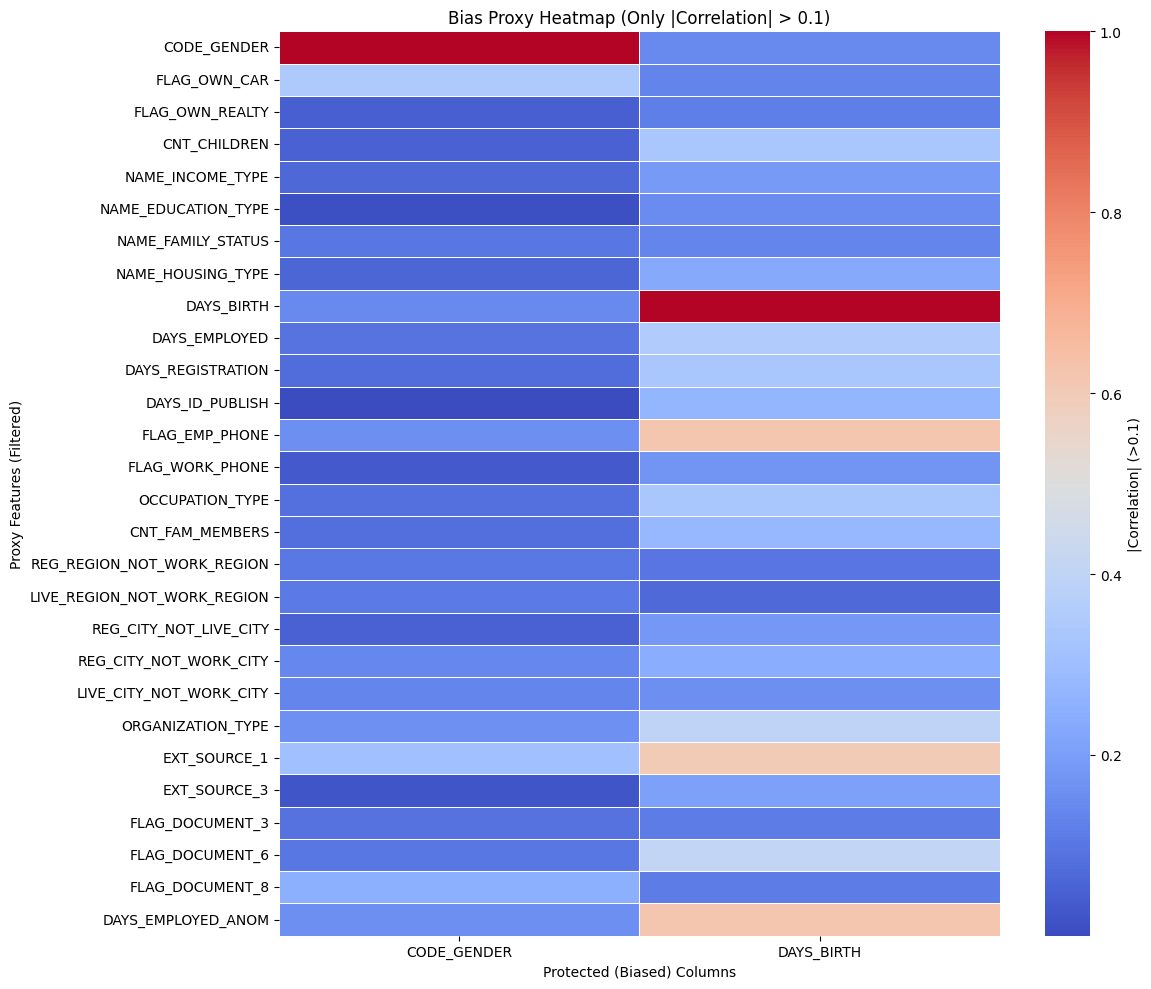

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# corr_sub = corr[valid_bcols]  # Ensure corr_sub already exists

# 1. Identify features with correlation > cutoff with ANY biased column
mask = corr_sub.abs().max(axis=1) > cutoff

# 2. Filter correlation matrix to only proxy features
corr_filtered = corr_sub[mask]

# 3. Plot heatmap of only high-correlation proxy features
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_filtered.abs(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': f'|Correlation| (>{cutoff})'}
)

plt.title(f"Bias Proxy Heatmap (Only |Correlation| > {cutoff})")
plt.xlabel("Protected (Biased) Columns")
plt.ylabel("Proxy Features (Filtered)")
plt.tight_layout()
plt.show()


So there are a lot of features that are correlated with gender and age. However, if we were to drop all of these features, our model would not be very accurate. To solve this problem, we will run an overlap test to identify features that can cause a positivity violation with our protected classes of gender and age.

In [51]:
#  0. Convert categorical to numeric for correlation & overlap
train_corr = make_numeric_for_corr(train)

#  1. Define protected variables
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']   # core sensitive features

#  2. Create Gender Binary (0 = M, 1 = F)
train['_GENDER_BIN'] = (train['CODE_GENDER'] == 'F').astype(int)

#  3. Create Age Group Bins for positivity testing
# DAYS_BIRTH is negative in Home Credit, so invert it:
train['_AGE'] = -train['DAYS_BIRTH']

# Use quartiles for overlap testing
train['_AGE_BIN'] = pd.qcut(train['_AGE'], q=4, labels=False, duplicates='drop')

#  4. Define candidate (non-protected) features
protected_vars = biased_cols + ['_GENDER_BIN', '_AGE_BIN', '_AGE']

candidate_features = [
    c for c in train.columns
    if c not in protected_vars and c not in ['TARGET']
]

print("Number of candidate features:", len(candidate_features))


#  5. POSITIVITY TEST FOR GENDER (M vs F)

female_unique = train.loc[train['_GENDER_BIN'] == 1, candidate_features].nunique()
viol_female = list(female_unique[female_unique < 2].index)

male_unique   = train.loc[train['_GENDER_BIN'] == 0, candidate_features].nunique()
viol_male = list(male_unique[male_unique < 2].index)

print("\n Gender Positivity Violations ")
print("Violates for FEMALES:", viol_female)
print("Violates for MALES:", viol_male)


#  6. POSITIVITY TEST FOR AGE (each age bin)

viol_age_bins = {}

for age_group in sorted(train['_AGE_BIN'].dropna().unique()):
    gmask = train['_AGE_BIN'] == age_group
    nunique_vals = train.loc[gmask, candidate_features].nunique()
    viol = list(nunique_vals[nunique_vals < 2].index)
    viol_age_bins[int(age_group)] = viol

print("\n Age Positivity Violations ")
for k, v in viol_age_bins.items():
    print(f"Age bin {k}: {v}")


#  7. Combine all violations

positivity_violations = set(viol_female) | set(viol_male)

for vlist in viol_age_bins.values():
    positivity_violations |= set(vlist)

positivity_violations = sorted(positivity_violations)

print("\n ALL Positivity Violations Across Gender + Age ")
print(positivity_violations)


Number of candidate features: 116

 Gender Positivity Violations 
Violates for FEMALES: ['FLAG_MOBIL']
Violates for MALES: []

 Age Positivity Violations 
Age bin 0: ['FLAG_DOCUMENT_12']
Age bin 1: ['FLAG_MOBIL']
Age bin 2: ['FLAG_MOBIL']
Age bin 3: ['FLAG_MOBIL', 'FLAG_DOCUMENT_12']

 ALL Positivity Violations Across Gender + Age 
['FLAG_DOCUMENT_12', 'FLAG_MOBIL']


This is a very interesting result. The test we just ran studied the dataset for positivity (overlap) violations. In the certain protected groups, these two features showed no variability. For females for example, the FLAG_MOBIL variable always has the same result. This flag also presents itself as an age-related bias. With a lack of variability, these features still reinforce structural bias and undermine the fairness adjusted modeling technique.

In [52]:
# Last step: Drop all the biased columns from the unbiased set

all_biased_to_drop = set(biased_cols) | set(proxy_features) | set(positivity_violations)

print("Dropping these biased features:", all_biased_to_drop)

train_unbiased = train.drop(columns=all_biased_to_drop)
test_unbiased = test.drop(columns=all_biased_to_drop)

print(f"Dropped {len(all_biased_to_drop)} features. This is {(len(all_biased_to_drop) / len(train_biased.columns)) * 100:.2f}% of the original.")


Dropping these biased features: {'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'FLAG_WORK_PHONE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED_ANOM', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'FLAG_DOCUMENT_12', 'REG_REGION_NOT_WORK_REGION', 'OCCUPATION_TYPE', 'FLAG_MOBIL', 'DAYS_BIRTH', 'EXT_SOURCE_3', 'DAYS_REGISTRATION', 'FLAG_EMP_PHONE', 'EXT_SOURCE_1', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_8', 'NAME_INCOME_TYPE', 'FLAG_DOCUMENT_6', 'CNT_FAM_MEMBERS', 'CODE_GENDER', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION'}
Dropped 30 features. This is 25.21% of the original.


It is important to note that most columns dropped here explode the dimensionality when the data is one-hot encoded.

In [53]:
# Run biased pipeline
X_biased_enc, X_test_biased_enc, y_biased, feature_names_biased, ct_biased = \
    preprocess_and_encode(train_biased, test_biased)

print("Biased train shape:", X_biased_enc.shape)
print("Biased test shape:", X_test_biased_enc.shape)

# Run unbiased pipeline
X_unbiased_enc, X_test_unbiased_enc, y_unbiased, feature_names_unbiased, ct_unbiased = \
    preprocess_and_encode(train_unbiased, test_unbiased)

print("Unbiased train shape:", X_unbiased_enc.shape)
print("Unbiased test shape:", X_test_unbiased_enc.shape)

Biased train shape: (307511, 230)
Biased test shape: (48744, 230)
Unbiased train shape: (307511, 102)
Unbiased test shape: (48744, 102)


# Training Biased and Unbiased Models

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import seaborn as sns
from sklearn.model_selection import cross_val_predict

def scores(y_true, y_pred, y_pred_proba, title="Model Evaluation"):
    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Print metric summary
    print(f"{title}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC-AUC:", auc)
    print("\nConfusion Matrix (Raw Values):\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [55]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [57]:
spark = SparkSession.builder.getOrCreate()


What I will eventually do is quantify how much the feature input weights in the model that has more features has on the output by directly comparing the two models. I will then need a vector which quantifies and tells the BIASED model how to adjust the weight of the input features to be unbiased, and the same for the inverse task (make an unbiased model biased).

In [58]:
# ==== Spark ML Random Forest on BIASED encoded data ====

label_col = "TARGET"

# 1) Wrap encoded arrays into pandas
biased_train_pdf = pd.DataFrame(X_biased_enc, columns=feature_names_biased)
biased_train_pdf[label_col] = y_biased.values

biased_test_pdf = pd.DataFrame(X_test_biased_enc, columns=feature_names_biased)

# median imputation to remove NaNs (train medians used for both)
train_medians = biased_train_pdf[feature_names_biased].median(numeric_only=True)

biased_train_pdf[feature_names_biased] = biased_train_pdf[feature_names_biased].fillna(train_medians)
biased_test_pdf[feature_names_biased]  = biased_test_pdf[feature_names_biased].fillna(train_medians)

# 1b) Now convert to Spark DataFrames
biased_train_sdf = spark.createDataFrame(biased_train_pdf)
biased_test_sdf  = spark.createDataFrame(biased_test_pdf)

# 2) Train/validation split (Spark equivalent of CV here)
train_sdf, val_sdf = biased_train_sdf.randomSplit([0.8, 0.2], seed=42)

# 3) Spark ML pipeline: VectorAssembler + RandomForest
assembler_biased = VectorAssembler(
    inputCols=feature_names_biased.tolist(),  # all encoded features
    outputCol="features",
    handleInvalid="keep"
)

rf_biased = RandomForestClassifier(
    labelCol=label_col,
    featuresCol="features",
    numTrees=50,
    maxDepth=6,
    featureSubsetStrategy="sqrt",
    seed=42
)

rf_pipeline_biased = Pipeline(stages=[assembler_biased, rf_biased])

# 4) Fit on train split and evaluate on validation
rf_model_biased = rf_pipeline_biased.fit(train_sdf)
val_pred_biased = rf_model_biased.transform(val_sdf)

# Convert val predictions to pandas to reuse your scores() function
val_pd_biased = val_pred_biased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")  # P(y=1)
).toPandas()

val_pd_biased["y_pred"] = (val_pd_biased["p"] >= 0.5).astype(int)

scores(
    val_pd_biased["y"],
    val_pd_biased["y_pred"],
    val_pd_biased["p"],
    title="Model Evaluation (Biased – Spark RF)"
)

# 5) Train final RF on all biased training data
rf_final_biased = rf_pipeline_biased.fit(biased_train_sdf)

# 6) Predict on biased test data (Spark equivalent of lgbm_test_pred)
test_pred_biased = rf_final_biased.transform(biased_test_sdf)

test_pd_biased = test_pred_biased.select(
    vector_to_array("probability")[1].alias("TARGET_PROB")
).toPandas()

rf_biased_test_pred = test_pd_biased["TARGET_PROB"].values  # same role as lgbm_test_pred


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.readRDDFromFile.
: java.lang.OutOfMemoryError: Java heap space


Model Evaluation (Biased – Sklearn RF)
Accuracy: 0.6706751953588652
Precision: 0.14960673230295363
Recall: 0.6574018126888218
F1: 0.24374397921007235
ROC-AUC: 0.7210828389231401

Confusion Matrix (Raw Values):
 [[189920  92766]
 [  8505  16320]]


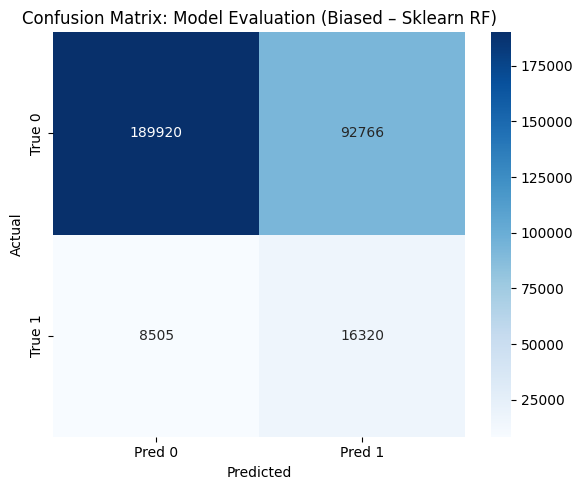


Top 20 Random Forest Features (Biased – Sklearn):
remainder__EXT_SOURCE_2                                      0.215225
remainder__EXT_SOURCE_3                                      0.190072
remainder__DAYS_EMPLOYED                                     0.062647
remainder__EXT_SOURCE_1                                      0.058944
onehot__NAME_EDUCATION_TYPE_Higher education                 0.040944
remainder__DAYS_BIRTH                                        0.039770
remainder__AMT_GOODS_PRICE                                   0.032487
remainder__DAYS_LAST_PHONE_CHANGE                            0.025441
remainder__FLAG_EMP_PHONE                                    0.024897
onehot__NAME_EDUCATION_TYPE_Secondary / secondary special    0.019693
onehot__NAME_INCOME_TYPE_Working                             0.017901
onehot__CODE_GENDER_F                                        0.017415
onehot__CODE_GENDER_M                                        0.016551
remainder__AMT_CREDIT                  

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

label_col = "TARGET"

# 1) Median imputation on encoded arrays (same idea as before)

imputer_biased = SimpleImputer(strategy="median")
X_biased_enc_imputed = imputer_biased.fit_transform(X_biased_enc)
X_test_biased_enc_imputed = imputer_biased.transform(X_test_biased_enc)

# 2) Define Random Forest model (similar hyperparams to Spark RF)

rf_biased = RandomForestClassifier(
    n_estimators=50,        # similar to numTrees=50
    max_depth=6,           # similar to Spark RF
    max_features="sqrt",   # similar to featureSubsetStrategy="sqrt"
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# 3) Cross-validated predictions (5-fold) to mimic what you were doing with LGBM

rf_biased_pred = cross_val_predict(
    rf_biased,
    X_biased_enc_imputed,
    y_biased,
    cv=5,
    method="predict"
)

rf_biased_pred_proba = cross_val_predict(
    rf_biased,
    X_biased_enc_imputed,
    y_biased,
    cv=5,
    method="predict_proba"
)[:, 1]

# 4) Use your existing scores() function

scores(
    y_biased,
    rf_biased_pred,
    rf_biased_pred_proba,
    title="Model Evaluation (Biased – Sklearn RF)"
)

# 5) Train final RF on ALL biased training data

rf_biased.fit(X_biased_enc_imputed, y_biased)

# 6) Predict on biased test data (equivalent of rf_biased_test_pred from Spark)

rf_biased_test_pred = rf_biased.predict_proba(X_test_biased_enc_imputed)[:, 1]

# 7) Feature importance (top 20)

rf_biased_importance = pd.Series(
    rf_biased.feature_importances_,
    index=feature_names_biased
).sort_values(ascending=False)

print("\nTop 20 Random Forest Features (Biased – Sklearn):")
print(rf_biased_importance.head(20))


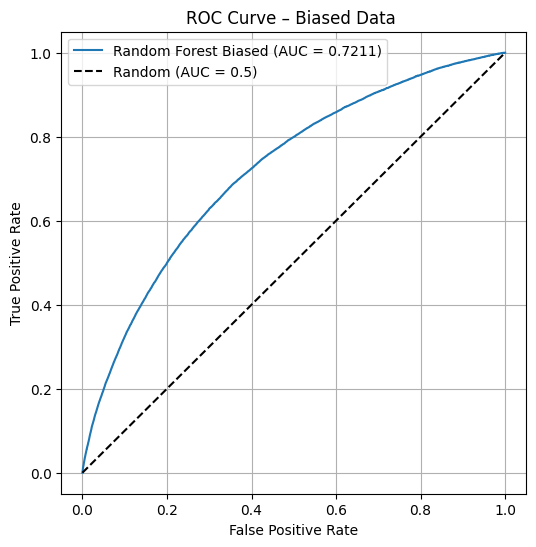

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_biased, rf_biased_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest Biased (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Biased Data ")
plt.legend()
plt.grid(True)
plt.show()


In [100]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ---- Extract true labels + probabilities from Spark predictions ----
pdf = val_pred_biased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")   # P(y=1)
).toPandas()

# ---- ROC + AUC ----
fpr, tpr, _ = roc_curve(pdf["y"], pdf["p"])
roc_auc = auc(fpr, tpr)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Biased Spark RF (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Biased Data (Spark Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


NameError: name 'val_pred_biased' is not defined

In [ ]:
# ==== Spark ML Random Forest on UNBIASED encoded data ====

label_col = "TARGET"

# 1) Wrap encoded arrays into pandas
unbiased_train_pdf = pd.DataFrame(X_unbiased_enc, columns=feature_names_unbiased)
unbiased_train_pdf[label_col] = y_unbiased.values

unbiased_test_pdf = pd.DataFrame(X_test_unbiased_enc, columns=feature_names_unbiased)

# Median imputation to remove NaNs (use train medians for both)
train_medians_unbiased = unbiased_train_pdf[feature_names_unbiased].median(numeric_only=True)

unbiased_train_pdf[feature_names_unbiased] = unbiased_train_pdf[feature_names_unbiased].fillna(
    train_medians_unbiased
)
unbiased_test_pdf[feature_names_unbiased] = unbiased_test_pdf[feature_names_unbiased].fillna(
    train_medians_unbiased
)

# 2) Convert to Spark DataFrames
unbiased_train_sdf = spark.createDataFrame(unbiased_train_pdf)
unbiased_test_sdf  = spark.createDataFrame(unbiased_test_pdf)

# 3) Train/validation split (Spark equivalent of CV here)
train_sdf_u, val_sdf_u = unbiased_train_sdf.randomSplit([0.8, 0.2], seed=42)

# 4) Spark ML pipeline: VectorAssembler + RandomForest
assembler_unbiased = VectorAssembler(
    inputCols=feature_names_unbiased.tolist(),  # all encoded features (unbiased)
    outputCol="features",
    handleInvalid="keep"
)

rf_unbiased = RandomForestClassifier(
    labelCol=label_col,
    featuresCol="features",
    numTrees=50,
    maxDepth=6,
    featureSubsetStrategy="sqrt",
    seed=42
)

rf_pipeline_unbiased = Pipeline(stages=[assembler_unbiased, rf_unbiased])

# 5) Fit on train split and evaluate on validation
rf_model_unbiased = rf_pipeline_unbiased.fit(train_sdf_u)
val_pred_unbiased = rf_model_unbiased.transform(val_sdf_u)

# Convert val predictions to pandas to reuse your scores() function
val_pd_unbiased = val_pred_unbiased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")  # P(y=1)
).toPandas()

val_pd_unbiased["y_pred"] = (val_pd_unbiased["p"] >= 0.5).astype(int)

scores(
    val_pd_unbiased["y"],
    val_pd_unbiased["y_pred"],
    val_pd_unbiased["p"],
    title="Model Evaluation (Unbiased – Spark RF)"
)

# 6) Train final RF on all unbiased training data
rf_final_unbiased = rf_pipeline_unbiased.fit(unbiased_train_sdf)

# 7) Predict on unbiased test data
test_pred_unbiased = rf_final_unbiased.transform(unbiased_test_sdf)

test_pd_unbiased = test_pred_unbiased.select(
    vector_to_array("probability")[1].alias("TARGET_PROB")
).toPandas()

rf_unbiased_test_pred = test_pd_unbiased["TARGET_PROB"].values


Model Evaluation (Unbiased – Sklearn RF)
Accuracy: 0.6357723788742516
Precision: 0.1284658592091917
Recall: 0.6071299093655589
F1: 0.21206066916171878
ROC-AUC: 0.6658804555485605

Confusion Matrix (Raw Values):
 [[180435 102251]
 [  9753  15072]]


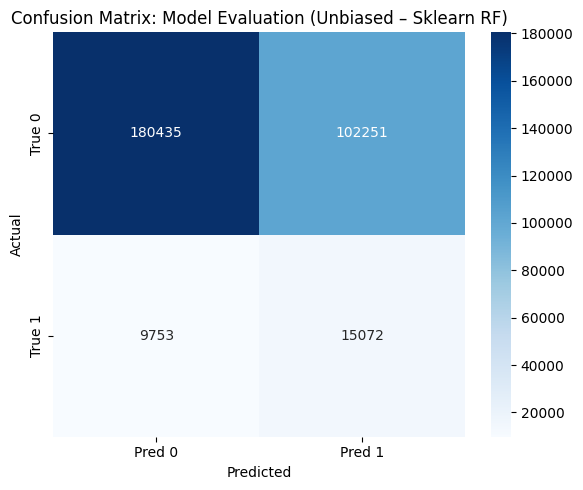


Top 20 Random Forest Features (Unbiased – Sklearn):
remainder__EXT_SOURCE_2                    0.396582
remainder__DAYS_LAST_PHONE_CHANGE          0.090640
remainder__AMT_GOODS_PRICE                 0.068618
remainder__AMT_CREDIT                      0.038759
remainder__REGION_RATING_CLIENT_W_CITY     0.037800
remainder__REGION_RATING_CLIENT            0.035064
remainder__AMT_ANNUITY                     0.032389
remainder__OWN_CAR_AGE                     0.022053
binary__NAME_CONTRACT_TYPE                 0.021261
remainder__REGION_POPULATION_RELATIVE      0.017133
remainder__FLOORSMAX_AVG                   0.016853
remainder__TOTALAREA_MODE                  0.016774
remainder__LIVINGAREA_MEDI                 0.015577
remainder__FLOORSMAX_MEDI                  0.013140
remainder__ELEVATORS_MODE                  0.011219
remainder__DEF_60_CNT_SOCIAL_CIRCLE        0.009270
remainder__YEARS_BEGINEXPLUATATION_MEDI    0.008405
remainder__DEF_30_CNT_SOCIAL_CIRCLE        0.008122
remainder__

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
import pandas as pd

label_col = "TARGET"

# 1) Median imputation (fit on train, apply to test)
imputer_unbiased = SimpleImputer(strategy="median")
X_unbiased_enc_imputed = imputer_unbiased.fit_transform(X_unbiased_enc)
X_test_unbiased_enc_imputed = imputer_unbiased.transform(X_test_unbiased_enc)

# 2) Random Forest (sklearn) — match Spark-ish params
rf_unbiased = RandomForestClassifier(
    n_estimators=50,        # ~ numTrees=50
    max_depth=6,           # ~ maxDepth=6
    max_features="sqrt",   # ~ featureSubsetStrategy="sqrt"
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# 3) Cross-validated predictions (5-fold)
rf_unbiased_pred = cross_val_predict(
    rf_unbiased,
    X_unbiased_enc_imputed,
    y_unbiased,
    cv=5,
    method="predict"
)

rf_unbiased_pred_proba = cross_val_predict(
    rf_unbiased,
    X_unbiased_enc_imputed,
    y_unbiased,
    cv=5,
    method="predict_proba"
)[:, 1]

# 4) Reuse your existing scores() function
scores(
    y_unbiased,
    rf_unbiased_pred,
    rf_unbiased_pred_proba,
    title="Model Evaluation (Unbiased – Sklearn RF)"
)

# 5) Fit final model on ALL unbiased training data
rf_unbiased.fit(X_unbiased_enc_imputed, y_unbiased)

# 6) Predict on unbiased test data
rf_unbiased_test_pred = rf_unbiased.predict_proba(X_test_unbiased_enc_imputed)[:, 1]

# 7) Feature importance (top 20)
rf_unbiased_importance = pd.Series(
    rf_unbiased.feature_importances_,
    index=feature_names_unbiased
).sort_values(ascending=False)

print("\nTop 20 Random Forest Features (Unbiased – Sklearn):")
print(rf_unbiased_importance.head(20))


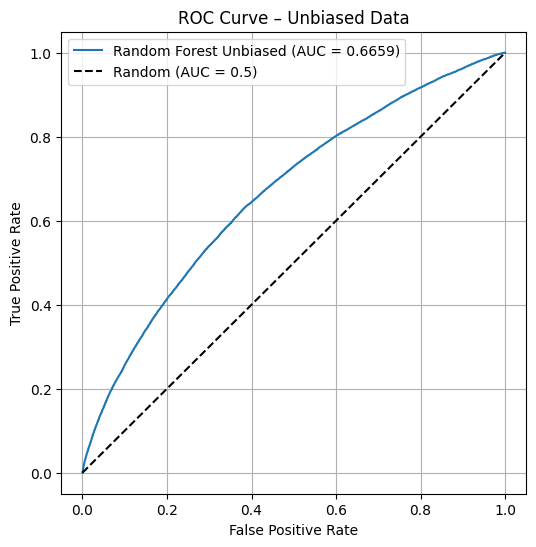

In [107]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_unbiased, rf_unbiased_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest Unbiased (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Unbiased Data")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


In [93]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ---- Extract true labels + probabilities (UNBIASED) ----
pdf_unbiased = val_pred_unbiased.select(
    col("TARGET").alias("y"),
    vector_to_array("probability")[1].alias("p")   # P(y=1)
).toPandas()

# ---- Compute ROC curve ----
fpr_u, tpr_u, _ = roc_curve(pdf_unbiased["y"], pdf_unbiased["p"])

# ---- Plot ----
plt.plot(fpr_u, tpr_u, label="ROC Curve (Unbiased)")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Unbiased Encoded Data")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'val_pred_unbiased' is not defined

In [ ]:
# ==== Spark ML Logistic Regression on BIASED encoded data ====

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

label_col = "TARGET"

# 1) Wrap encoded arrays into pandas (same as RF)
biased_train_pdf = pd.DataFrame(X_biased_enc, columns=feature_names_biased)
biased_train_pdf[label_col] = y_biased.values

biased_test_pdf = pd.DataFrame(X_test_biased_enc, columns=feature_names_biased)

# median imputation to remove NaNs (train medians used for both)
train_medians = biased_train_pdf[feature_names_biased].median(numeric_only=True)

biased_train_pdf[feature_names_biased] = biased_train_pdf[feature_names_biased].fillna(train_medians)
biased_test_pdf[feature_names_biased]  = biased_test_pdf[feature_names_biased].fillna(train_medians)

# 1b) Now convert to Spark DataFrames
biased_train_sdf = spark.createDataFrame(biased_train_pdf)
biased_test_sdf  = spark.createDataFrame(biased_test_pdf)

# 2) Train/validation split (Spark equivalent of CV here)
train_sdf, val_sdf = biased_train_sdf.randomSplit([0.8, 0.2], seed=42)

# 3) Spark ML pipeline: VectorAssembler + LogisticRegression
assembler_biased = VectorAssembler(
    inputCols=feature_names_biased.tolist(),  # all encoded features
    outputCol="features",
    handleInvalid="keep"
)

# LogisticRegression params: you can tune regParam / elasticNetParam / maxIter as needed
lr_biased = LogisticRegression(
    labelCol=label_col,
    featuresCol="features",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,   # 0=L2, 1=L1, between=elastic net
    standardization=True,  # whether to standardize features before training
    family="binomial"
)

lr_pipeline_biased = Pipeline(stages=[assembler_biased, lr_biased])

# 4) Fit on train split and evaluate on validation
lr_model_biased = lr_pipeline_biased.fit(train_sdf)
val_pred_biased = lr_model_biased.transform(val_sdf)

# Convert val predictions to pandas to reuse your scores() function
# vector_to_array("probability")[1] gives P(y=1)
val_pd_biased = val_pred_biased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")
).toPandas()

val_pd_biased["y_pred"] = (val_pd_biased["p"] >= 0.5).astype(int)

scores(
    val_pd_biased["y"],
    val_pd_biased["y_pred"],
    val_pd_biased["p"],
    title="Model Evaluation (Biased – Spark LR)"
)

# 5) Train final Logistic Regression on all biased training data
lr_final_biased = lr_pipeline_biased.fit(biased_train_sdf)

# 6) Predict on biased test data (Spark equivalent of lgbm_test_pred)
test_pred_biased = lr_final_biased.transform(biased_test_sdf)

test_pd_biased = test_pred_biased.select(
    vector_to_array("probability")[1].alias("TARGET_PROB")
).toPandas()

lr_biased_test_pred = test_pd_biased["TARGET_PROB"].values  # same role as lgbm_test_pred

# ---- (Optional) ROC plot on validation set ----
# Extract true labels + probabilities (we already have val_pred_biased above)
pdf = val_pred_biased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")
).toPandas()

fpr, tpr, _ = roc_curve(pdf["y"], pdf["p"])

plt.plot(fpr, tpr, label="ROC Curve (Logistic Regression)")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ---- lr_biased_test_pred now holds the predicted probabilities for the test set ----

In [ ]:
# ==== Spark ML Logistic Regression on UNBIASED encoded data ====

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

label_col = "TARGET"

# 1) Wrap encoded arrays into pandas (same pattern as RF)
unbiased_train_pdf = pd.DataFrame(X_unbiased_enc, columns=feature_names_unbiased)
unbiased_train_pdf[label_col] = y_unbiased.values

unbiased_test_pdf = pd.DataFrame(X_test_unbiased_enc, columns=feature_names_unbiased)

# Median imputation to remove NaNs (use train medians for both)
train_medians_unbiased = unbiased_train_pdf[feature_names_unbiased].median(numeric_only=True)

unbiased_train_pdf[feature_names_unbiased] = unbiased_train_pdf[feature_names_unbiased].fillna(
    train_medians_unbiased
)
unbiased_test_pdf[feature_names_unbiased] = unbiased_test_pdf[feature_names_unbiased].fillna(
    train_medians_unbiased
)

# 2) Convert to Spark DataFrames
unbiased_train_sdf = spark.createDataFrame(unbiased_train_pdf)
unbiased_test_sdf  = spark.createDataFrame(unbiased_test_pdf)

# 3) Train/validation split (Spark equivalent of CV here)
train_sdf_u, val_sdf_u = unbiased_train_sdf.randomSplit([0.8, 0.2], seed=42)

# 4) Spark ML pipeline: VectorAssembler + LogisticRegression
assembler_unbiased = VectorAssembler(
    inputCols=feature_names_unbiased.tolist(),  # all encoded features (unbiased)
    outputCol="features",
    handleInvalid="keep"
)

# LogisticRegression params: tune regParam / elasticNetParam / maxIter as needed
lr_unbiased = LogisticRegression(
    labelCol=label_col,
    featuresCol="features",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,   # 0=L2, 1=L1
    standardization=True,
    family="binomial"
)

lr_pipeline_unbiased = Pipeline(stages=[assembler_unbiased, lr_unbiased])

# 5) Fit on train split and evaluate on validation
lr_model_unbiased = lr_pipeline_unbiased.fit(train_sdf_u)
val_pred_unbiased = lr_model_unbiased.transform(val_sdf_u)

# Convert val predictions to pandas to reuse your scores() function
val_pd_unbiased = val_pred_unbiased.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")  # P(y=1)
).toPandas()

val_pd_unbiased["y_pred"] = (val_pd_unbiased["p"] >= 0.5).astype(int)

scores(
    val_pd_unbiased["y"],
    val_pd_unbiased["y_pred"],
    val_pd_unbiased["p"],
    title="Model Evaluation (Unbiased – Spark LR)"
)

# 6) Train final Logistic Regression on all unbiased training data
lr_final_unbiased = lr_pipeline_unbiased.fit(unbiased_train_sdf)

# 7) Predict on unbiased test data
test_pred_unbiased = lr_final_unbiased.transform(unbiased_test_sdf)

test_pd_unbiased = test_pred_unbiased.select(
    vector_to_array("probability")[1].alias("TARGET_PROB")
).toPandas()

lr_unbiased_test_pred = test_pd_unbiased["TARGET_PROB"].values

# ---- Extract true labels + probabilities (UNBIASED) for ROC ----
pdf_unbiased = val_pred_unbiased.select(
    col("TARGET").alias("y"),
    vector_to_array("probability")[1].alias("p")   # P(y=1)
).toPandas()

# ---- Compute ROC curve ----
fpr_u, tpr_u, _ = roc_curve(pdf_unbiased["y"], pdf_unbiased["p"])

# ---- Plot ----
plt.plot(fpr_u, tpr_u, label="ROC Curve (Unbiased - Logistic Regression)")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Unbiased Encoded Data (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

# ---- lr_unbiased_test_pred now holds the predicted probabilities for the unbiased test set ----


Model Evaluation (Biased – Sklearn LR)
Accuracy: 0.6208168163090101
Precision: 0.1298617496652632
Recall: 0.648539778449144
F1: 0.21639348669045652
ROC-AUC: 0.6804618133091123

Confusion Matrix (Raw Values):
 [[174808 107878]
 [  8725  16100]]


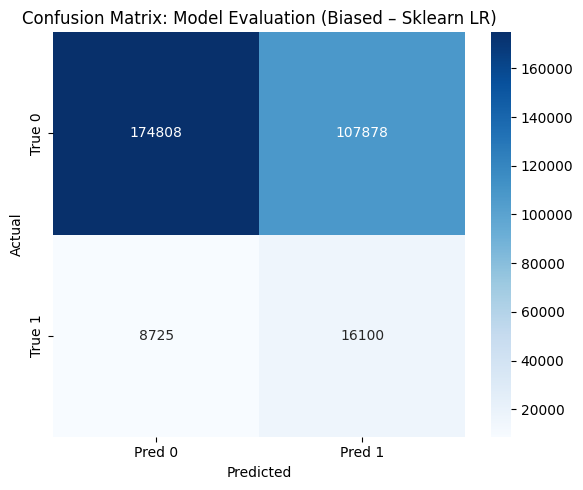

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
import numpy as np

# 1) Median imputation
imp_lr_b = SimpleImputer(strategy="median")
X_biased_lr = imp_lr_b.fit_transform(X_biased_enc)
X_test_biased_lr = imp_lr_b.transform(X_test_biased_enc)

# 2) Logistic Regression
lr_biased = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="liblinear",   # safe default for binary + high-dim sparse-ish data
    random_state=42
)

# 3) CV predictions
lr_biased_pred = cross_val_predict(lr_biased, X_biased_lr, y_biased, cv=5, method="predict")
lr_biased_pred_proba = cross_val_predict(lr_biased, X_biased_lr, y_biased, cv=5, method="predict_proba")[:, 1]

# 4) Your metrics
scores(y_biased, lr_biased_pred, lr_biased_pred_proba, title="Model Evaluation (Biased – Sklearn LR)")

# 5) Fit on all + test probs
lr_biased.fit(X_biased_lr, y_biased)
lr_biased_test_pred = lr_biased.predict_proba(X_test_biased_lr)[:, 1]
